## Minimum Spectral Entropy Demonstration (Phase and Delay)

This notebook demonstrates a method for controlling stochastic delay and phase noise in $H(\nu,t)e^{i(\phi_t+\epsilon_t \nu)}$, where $H(\nu,t)$ is the dynamic frequency response determined by dynamic cyclic spectroscopy, $\phi_t$ and $\epsilon_t$ are the unknown degenerate phase and delay at time $t$.

The method is based on minimizing the spectral entropy in $h(\tau,\omega)$ by varying $\phi_t$ and $\epsilon_t$.

In [1]:
from scipy.fft import rfft, fft, fftshift, ifft, fftn, ifftn
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import psrchive

def freq2time(hf, axis=0):
    return ifft(hf, axis=axis, norm="ortho")

def time2freq(ht, axis=0):
    return fft(ht, axis=axis, norm="ortho")

## Spectral Entropy

Defined as $$U = - \sum_j \sum_k p_{jk} \log_2 p_{jk},$$
where $p_{jk}$ is the fractional power spectral density,

\begin{equation}
p_{jk} = P_{jk} \Sigma_P^{-1},
\end{equation}

$P_{jk} = | h^\prime(\tau_j;\omega_k) |^2$ is the power at a
given delay and Doppler shift, and

\begin{equation}
\Sigma_P =  \sum_j \sum_k P_{jk}
\end{equation}

is the total power summed over all delays and Doppler shifts, which remains constant
as the values of $\phi_t$ and $\epsilon_t$ are varied.

See https://www.overleaf.com/read/mjqhtxmtpmmd#19ec75 for derivation of the partial derivatives $dU/d\phi_t$ and $dU/d\epsilon_t$.

In [2]:
def spectral_entropy_grad(alpha, h_time_freq):
    """
    Calculates the total spectral entropy of the time-to-Doppler forward Fourier transform
    and freq-to-delay inverse Fourier transform of the input h_time_freq after mupltiplying each row/time (except the first) by phi
    and shifting each row/time by delay epsilon

    Args:
    alpha: A 1D array of (Ntime - 1) real-valued phase shifts, in radians,
        and (Ntime - 1) real-valued delays, in radians per cycle, to be applied to each row except the first
    h_time_freq: the dynamic frequency response, a 2D array of Ntime * Nfreq complex-values

    Returns:
    The spectral entropy and its gradient with respect to the phase shifts
    """

    Ntime, Nchan = h_time_freq.shape
    
    phs = np.zeros(Ntime)
    eps = np.zeros(Ntime)

    phs[1:] = alpha[0:Ntime-1]
    eps[1:] = alpha[Ntime-1:]

    nus = np.fft.fftfreq(Nchan)
    h_time_freq_prime = h_time_freq * np.exp(1j * np.outer(eps, nus))
    dh_time_freq_prime_deps_oni = np.multiply(h_time_freq_prime, nus[np.newaxis, :])

    h_time_delay_prime = ifft(h_time_freq_prime, axis=1, norm="ortho")
    dh_time_delay_prime_deps_oni = ifft(dh_time_freq_prime_deps_oni, axis=1, norm="ortho")

    phasors = np.exp(1.j * phs)
    h_time_delay_prime = np.multiply(h_time_delay_prime, phasors[:, np.newaxis])
    dh_time_delay_prime_deps_oni = np.multiply(dh_time_delay_prime_deps_oni, phasors[:, np.newaxis])
    
    h_doppler_delay_prime = fft(h_time_delay_prime, axis=0, norm="ortho")
    
    power_spectrum = np.abs(h_doppler_delay_prime)**2
    
    total_power = np.sum(power_spectrum)
    power_spectrum /= total_power
    log_power_spectrum = np.log2(power_spectrum + 1e-16)
    entropy = -np.sum(power_spectrum * log_power_spectrum)

    weighted_ifft = fft((1.+log_power_spectrum)*np.conj(h_doppler_delay_prime), axis=0, norm="ortho")

    # partial derivatives with respect to phi_l
    gradient_phs = 2.0/total_power * np.sum( np.imag( weighted_ifft*h_time_delay_prime ), axis=1)
    grad_phs_power = np.sum(gradient_phs**2)

    # partial derivatives with respect to epsilon_l
    gradient_eps = 2.0/total_power * np.sum( np.imag( weighted_ifft*dh_time_delay_prime_deps_oni ), axis=1)    
    grad_eps_power = np.sum(gradient_eps**2)

    rms = np.sqrt(np.sum(phs**2) / (Ntime-1))
    print (f"rms={rms:.4g} rad; S={entropy} grad power phs={grad_phs_power:.4} eps={grad_eps_power:.4}")

    return entropy, np.concatenate((gradient_phs[1:],gradient_eps[1:]))

def spectral_entropy(h_time_freq):
    """
    Calculates the total spectral entropy of the time-to-Doppler forward Fourier transform 
    of the input h_time_delay

    Args:
    h_time_freq: the dynamic frequency response, a 2D array of Ntime * Nfreq complex-values

    Returns:
    The spectral entropy
    """
    nsub, nchan = h_time_freq.shape
    alpha = np.zeros(2*(nsub-1))
    entropy, grad = spectral_entropy_grad(alpha,h_time_freq)
    return entropy

## Minimize the spectral entropy using BFGS

In [3]:
from scipy.optimize import minimize

def circular(x):
    x[:] = np.fmod(x, 2.0*np.pi)

def minimize_spectral_entropy(h_time_freq):

    Ntime, Nchan = h_time_freq.shape
    initial_guess = np.zeros(2*(Ntime - 1))

    options = {"maxiter": 1000, "disp": True}

    result = minimize(
        spectral_entropy_grad,
        initial_guess,
        args=(h_time_freq,),
        method="BFGS",
        jac=True,
        callback=circular,
        options=options,
    )

    alpha = result.x
    phs = np.zeros(Ntime)
    eps = np.zeros(Ntime)

    phs[1:] = alpha[0:Ntime-1]
    eps[1:] = alpha[Ntime-1:]

    nus = np.fft.fftfreq(Nchan)
    h_time_freq_prime = h_time_freq * np.exp(1j * np.outer(eps, nus))

    phasors = np.exp(1.j * phs)
    h_time_freq[:,:] = np.multiply(h_time_freq_prime, phasors[:, np.newaxis])

## Astrophysical scattering screen

The file `giant_pulse_filters.fits` contains $H(\nu,t)$ the frequency reponse derived from the baseband voltage data for the giant pulse with the greatest S/N in each 20-second interval containing $t$.  Assuming that the intrinsic giant pulse is a delta function, each giant pulse can be treated as an estimate of the impulse response function, the Fourier transform of which is the frequency response.

In [4]:
filename = "giant_pulse_filters.fits"
ar = psrchive.Archive_load(filename)
ext = ar.get_dynamic_response()
data = ext.get_data()
nchan = ext.get_nchan()
ntime = ext.get_ntime()
h_time_freq = np.reshape(data, (ntime, nchan))

start_time = ext.get_minimum_epoch ()
end_time = ext.get_maximum_epoch ()
dT = (end_time-start_time).in_seconds() / ntime

print(f"start_time={start_time.printdays(13)} end_time={end_time.printdays(13)}")

bw = ext.get_bandwidth()
cfreq = ext.get_centre_frequency()

print(f"delta-T={dT} centre frequency={cfreq} bandwidth={bw}")

print(f"\nInitial Spectral Entropy: {spectral_entropy(h_time_freq)}\n")

h_time_delay = ifft(h_time_freq,axis=1,norm="ortho")

start_time=53873.3225115741006 end_time=53873.3634837963036
delta-T=19.999999990607847 centre frequency=428.0 bandwidth=4.0
rms=0 rad; S=16.601524061483957 grad power phs=2.413e-05 eps=1.832e-06

Initial Spectral Entropy: 16.601524061483957



Average Power: 1.0000000000000002


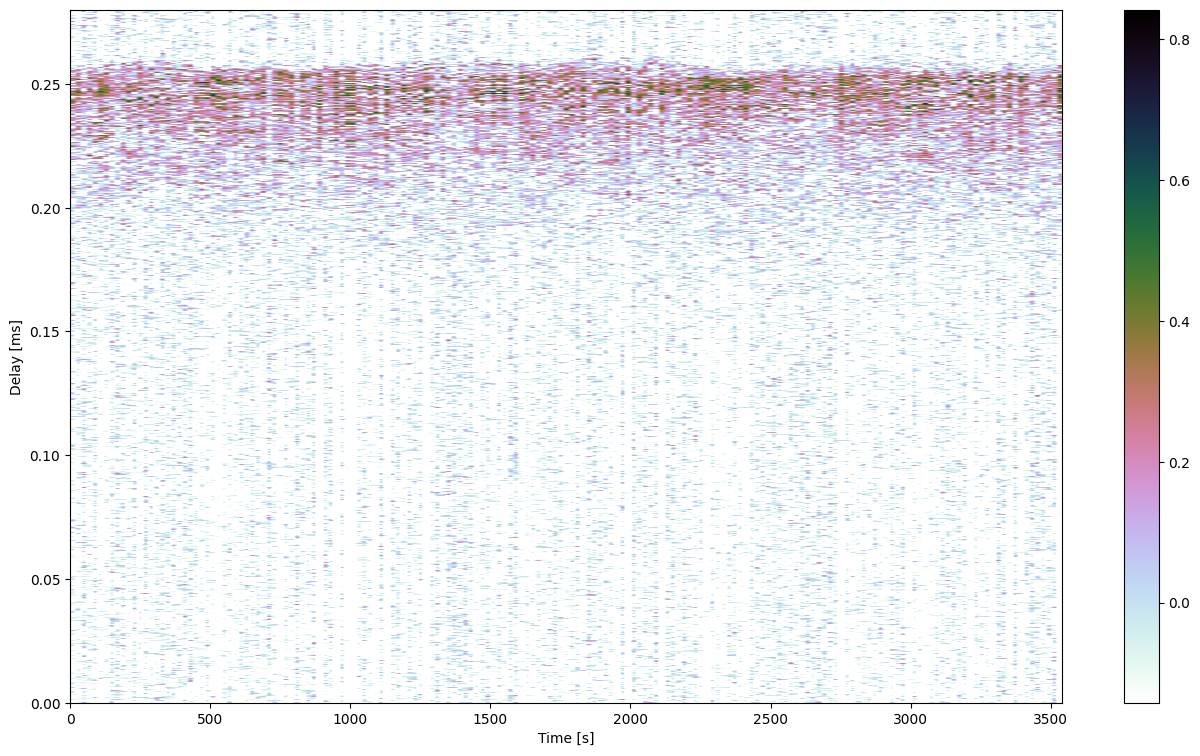

In [5]:
def plot_time_vs_delay (h_time_delay, dT, cfreq, bw):

    ntime, ntap = h_time_delay.shape
    
    power = np.sum(np.abs(h_time_delay)**2) / (ntime * ntap)
    print(f"Average Power: {power}")
 
    plotthis = np.log10(np.abs(h_time_delay) + 1e-2)
    plotmed = np.median(plotthis)

    delta_delay_mus = np.abs(1.0 / bw)
    max_delay_ms = delta_delay_mus * ntap * 1e-3
    extent=[0, dT*ntime, 0, max_delay_ms]
    
    fig, ax = plt.subplots(figsize=(16, 9))
    img = ax.imshow(plotthis.T, aspect="auto", origin="lower", cmap="cubehelix_r", vmin=plotmed, extent=extent)

    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Delay [ms]")
    fig.colorbar(img)

plot_time_vs_delay(h_time_delay, dT, cfreq, bw)

## Unaligned Wavefield

A Fourier transform along the delay axis yields $H(\nu,t)$, which is then passed to the plot function, which computes and plots the 2D FFT, $h(\tau,\omega)$.  This is expected to look like white Doppler noise because of the large time shifts $\epsilon_t$ that are clearly visible in the above plot.

rms=0 rad; S=16.601524061483957 grad power phs=2.413e-05 eps=1.832e-06
Spectral Entropy: 16.601524061483957


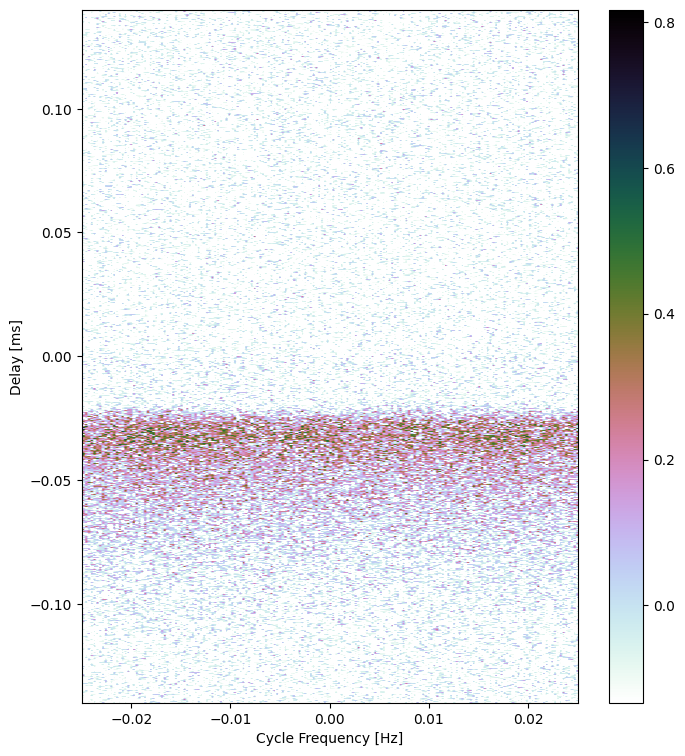

In [6]:
def plot_Doppler_vs_delay (h_time_freq, dT, cfreq, bw):

    print(f"Spectral Entropy: {spectral_entropy(h_time_freq)}")

    h_time_delay = freq2time(h_time_freq, axis=1)
    h_doppler_delay = time2freq(h_time_delay, axis=0)

    ntime, ntap = h_time_delay.shape

    delta_delay_mus = np.abs(1.0 / bw)
    max_delay_ms = delta_delay_mus * ntap * 0.5e-3
    max_Doppler_Hz = .5 / dT
    
    extent=[-max_Doppler_Hz, max_Doppler_Hz, -max_delay_ms, max_delay_ms]
    
    plotthis = np.log10(np.abs(fftshift(h_doppler_delay)) + 1e-2)
    plotmed = np.median(plotthis)
    fig, ax = plt.subplots(figsize=(8, 9))

    ax.set_xlabel("Cycle Frequency [Hz]")
    ax.set_ylabel("Delay [ms]")
    img = ax.imshow(plotthis.T, aspect="auto", origin="lower", cmap="cubehelix_r", vmin=plotmed, extent=extent)

    fig.colorbar(img)
    
plot_Doppler_vs_delay(h_time_freq, dT, cfreq, bw)

## Coarse alignment using the cross-correlation function.

Each impulse response in $h(\tau,t)$ is aligned to its neighbour and multiplied by a phase term, based on the cross-correlation between them.

In [7]:

def spectral_distance(alpha, z, w):
    """
    Calculates the magnitude of the difference between the two spectra in the two halve of two_spectra
    after mupltiplying the second one by an amplitude, phase, and phase gradient

    Args:
    alpha: A 1D array of 3 values: amplitude, phase, and slope
    two_spectra: the complex-valued spectra to be aligned

    Returns:
    The distance and its gradient with respect to the 3 parameters in alpha
    """

    Nchan = z.size
    phase = alpha[0]
    slope = alpha[1]
    amplitude = 1
    print(f"{amplitude=} {phase=} {slope=}")

    nus = np.fft.fftfreq(Nchan)
    wprime = amplitude * np.exp(1j * phase) * w * np.exp(1j * slope * nus)
    delta = z - wprime

    diff = np.sum(np.abs(delta)**2)

    del_amplitude = wprime / amplitude
    del_phase = 1j * wprime
    del_slope = 1j * nus * wprime

    ddiff_damp = -2 * np.sum ( np.real( np.conj(delta) * del_amplitude ) )
    ddiff_dphs = -2 * np.sum ( np.real( np.conj(delta) * del_phase ) )
    ddiff_dslo = -2 * np.sum ( np.real( np.conj(delta) * del_slope ) )

    print(f"{diff=} del_a={ddiff_damp} del_phi={ddiff_dphs} del_eps={ddiff_dslo}")
    return diff, [ddiff_dphs, ddiff_dslo]

def minimize_difference(z, w):

    Nchan = z.size
    initial_guess = np.zeros(2)

    ccf = fft( np.conj(w) * z )
    ccf_power = np.abs(ccf)**2
    imax = np.argmax(ccf_power)
    ph_max = np.angle(ccf[imax])

    print(f"{imax=} {ph_max=} {Nchan=}")
    
    initial_guess[0] = ph_max

    if imax < Nchan // 2:
        slope = imax
    else:
        slope = imax - Nchan

    initial_guess[1] = slope * 2.0 * np.pi

    options = {"maxiter": 1000, "disp": True, "gtol": 1e-12}
    
    result = minimize(
        spectral_distance,
        initial_guess,
        args=(z,w),
        method="BFGS",
        jac=True,
        # callback=circular,
        options=options,
    )

    alpha = result.x

    phase = alpha[0]
    slope = alpha[1]
    amplitude = 1
    
    nus = np.fft.fftfreq(Nchan)
    w[:] = amplitude * np.exp(1j * phase) * w * np.exp(1j * slope * nus)

def align_to_neighbour(subset):
    nt, ntau = subset.shape
    x = subset[0]
    for idx in range(1,nt):
        y = subset[idx]
        minimize_difference(x,y)
        x = y
        subset[idx,:] = y

In [8]:
align_to_neighbour(h_time_freq)
h_time_delay = ifft(h_time_freq,axis=1,norm="ortho")

imax=2 ph_max=2.578691554263042 Nchan=1120
amplitude=1 phase=2.578691554263042 slope=12.566370614359172
diff=1415.7324046468207 del_a=1415.7324046468207 del_phi=1.4210854715202004e-14 del_eps=25.821688222382498
amplitude=1 phase=2.5786915542630418 slope=11.556370614359178
diff=1419.4568274603105 del_a=1419.4568274603107 del_phi=-6.844975533109086 del_eps=-33.098334284800835
amplitude=1 phase=2.5786915542630418 slope=12.12498392611574
diff=1410.0173351819612 del_a=1410.0173351819612 del_phi=-3.543823616964117 del_eps=0.020738716298126736
amplitude=1 phase=5.8336960039828565 slope=11.67757548278263
diff=3059.546694322469 del_a=3059.5466943224687 del_phi=-87.04128613826406 del_eps=25.371793574001135
amplitude=1 phase=2.582263250620936 slope=12.124492987583327
diff=1410.0099562619291 del_a=1410.0099562619291 del_phi=-0.5828389700010597 del_eps=0.01722277380582682
amplitude=1 phase=2.582968706519364 slope=12.124113269957949
diff=1410.0097474199267 del_a=1410.0097474199267 del_phi=-6.6547240

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

imax=6 ph_max=-2.633665050941474 Nchan=1120
amplitude=1 phase=-2.633665050941474 slope=37.69911184307752
diff=921.5305799606624 del_a=921.5305799606625 del_phi=1.7053025658242404e-13 del_eps=-68.74316536165796
amplitude=1 phase=-2.6336650509414765 slope=38.709111843077515
diff=898.4368586696968 del_a=898.4368586696969 del_phi=-6.614052264852635 del_eps=23.451590194605792
amplitude=1 phase=2.2979700058480237 slope=38.80599355686202
diff=1955.9538607184936 del_a=1955.9538607184936 del_phi=-1308.4045570054382 del_eps=14.226351556328268
amplitude=1 phase=-2.625922257710961 slope=38.70926394984718
diff=898.4294212070674 del_a=898.4294212070675 del_phi=3.772355609134454 del_eps=23.4085682316427
amplitude=1 phase=-2.6259312178243626 slope=38.70862359142675
diff=898.4144163188255 del_a=898.4144163188257 del_phi=3.76510273350846 del_eps=23.349995248804078
amplitude=1 phase=-2.6259670582779693 slope=38.706062157745045
diff=898.354772506291 del_a=898.354772506291 del_phi=3.7360807655494135 del_ep

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

amplitude=1 phase=-3.226406973595683 slope=-48.63445616009054
diff=1488.8272556981847 del_a=1488.8272556981856 del_phi=1.014770845131352e-08 del_eps=4.3043091757510865e-08
amplitude=1 phase=-3.2264069735382477 slope=-48.634456160728625
diff=1488.8272556981847 del_a=1488.8272556981856 del_phi=-4.709832523985824e-11 del_eps=-4.6908255058042414e-11
         Current function value: 1488.827256
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
imax=1117 ph_max=2.982784972312313 Nchan=1120
amplitude=1 phase=2.982784972312313 slope=-18.84955592153876
diff=1642.1478301127659 del_a=1642.1478301127654 del_phi=8.526512829121202e-14 del_eps=87.41563560853419
amplitude=1 phase=2.982784972312312 slope=-19.859555921538757
diff=1582.5460643780702 del_a=1582.5460643780696 del_phi=16.72358077892809 del_eps=29.37490503966002
amplitude=1 phase=-1.686664089321324 slope=-21.29975319712643
diff=2300.3572561695923 del_a=2300.357256169592 del_phi=635.2346774900846 del_eps

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

## Coarsely-aligned Impulse Responses

It's reassuring to see temporally persistent features in the impulse responses.

Average Power: 1.0


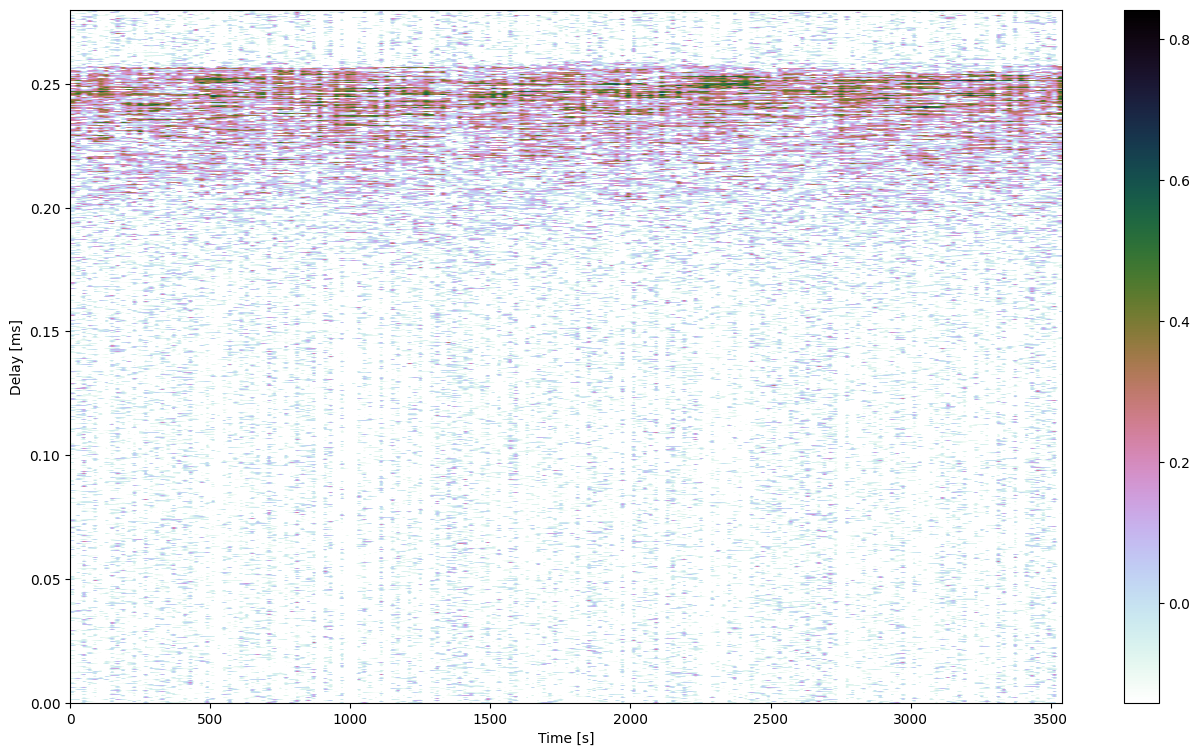

In [9]:
plot_time_vs_delay(h_time_delay, dT, cfreq, bw)

## Individually-aligned Response Wavefield

rms=0 rad; S=15.836039635403292 grad power phs=7.604e-05 eps=5.845e-06
Spectral Entropy: 15.836039635403292


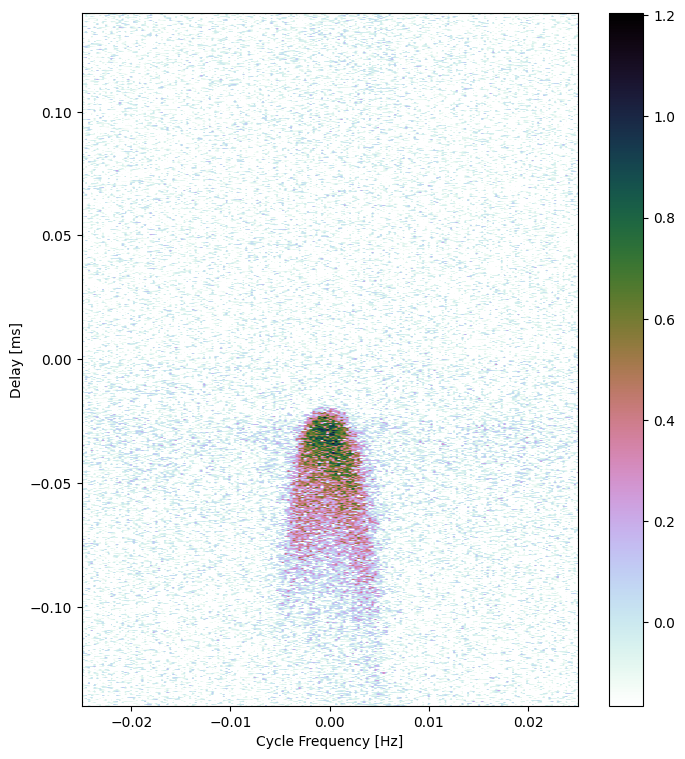

In [10]:
h_time_freq = fft(h_time_delay,axis=1,norm="ortho")
plot_Doppler_vs_delay(h_time_freq, dT, cfreq, bw)

## Perform fine alignment by minimizing the spectral entropy

In [11]:
minimize_spectral_entropy(h_time_freq)

rms=0 rad; S=15.836039635403292 grad power phs=7.604e-05 eps=5.845e-06
rms=0.0006555 rad; S=15.835958664878039 grad power phs=7.407e-05 eps=5.834e-06
rms=0.003278 rad; S=15.835644786852853 grad power phs=6.649e-05 eps=5.791e-06
rms=0.01377 rad; S=15.834549865010768 grad power phs=4.138e-05 eps=5.628e-06
rms=0.04634 rad; S=15.832782516760156 grad power phs=1.739e-05 eps=5.214e-06
rms=0.0533 rad; S=15.832701297709868 grad power phs=2.243e-05 eps=5.134e-06
rms=0.05521 rad; S=15.832664243712445 grad power phs=2.37e-05 eps=5.1e-06
rms=0.05735 rad; S=15.832593258566229 grad power phs=2.455e-05 eps=5.046e-06
rms=0.06039 rad; S=15.832457500072257 grad power phs=2.495e-05 eps=4.953e-06
rms=0.06527 rad; S=15.832203615729274 grad power phs=2.456e-05 eps=4.783e-06
rms=0.07393 rad; S=15.83175706521859 grad power phs=2.311e-05 eps=4.469e-06
rms=0.09095 rad; S=15.83111457910027 grad power phs=2.378e-05 eps=3.9e-06
rms=0.1022 rad; S=15.830814776408296 grad power phs=2.802e-05 eps=3.526e-06
rms=0.1034 

## Finely-aligned Wavefield

After fine alignment, an arc appears!  It's at a funny delay and Doppler shift, but it's a start!  The offeset in cycle frequency $\Delta\omega$ could be fixed by a applying a phase gradient along the time axis; i.e. $h^\prime(\tau,t)= h(\tau,t)\exp(i2\pi t\Delta\omega)$

rms=0 rad; S=15.814603708903036 grad power phs=2.196e-09 eps=1.642e-08
Spectral Entropy: 15.814603708903036


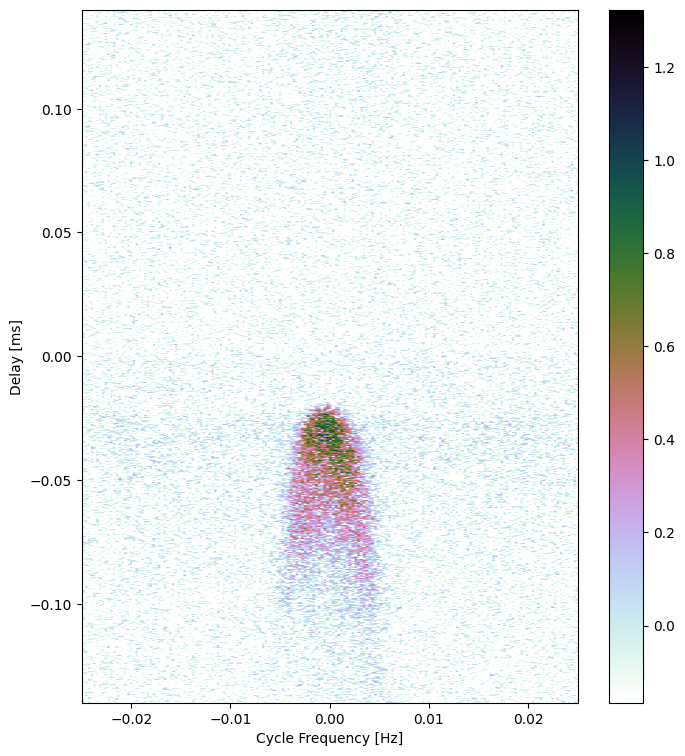

In [12]:
plot_Doppler_vs_delay(h_time_freq, dT, cfreq, bw)

Average Power: 1.0000000000000002


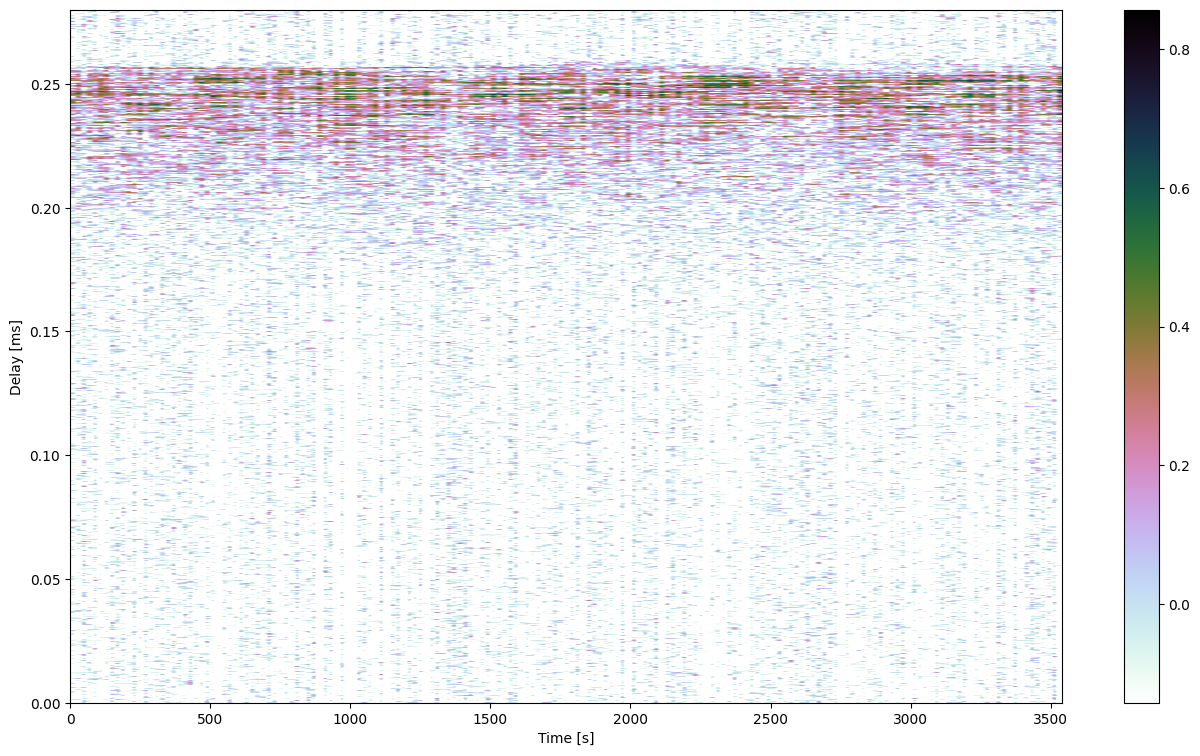

In [13]:
h_time_delay = ifft(h_time_freq,axis=1,norm="ortho")
plot_time_vs_delay(h_time_delay, dT, cfreq, bw)